<a href="https://colab.research.google.com/github/yendriferreira/Credit-Card-FraudML/blob/main/Selected_Features_Forwards_%26_RFECV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)


files = os.listdir('/kaggle/input/creditcardfraud')
print("Files in dataset directory:", files)

# Load the CSV into a DataFrame
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

Path to dataset files: /kaggle/input/creditcardfraud
Files in dataset directory: ['creditcard.csv']


In [2]:
#  IMPORTS Y CONFIGURACIÓN INICIAL
# ******************************************************************************
# SELECCIÓN DE CARACTERÍSTICAS: RFECV vs FORWARD SELECTION
# ******************************************************************************

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Librerías de ML
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,
                           precision_score, recall_score)

# Técnicas de balanceado
from imblearn.over_sampling import SMOTE

print("SELECCIÓN DE CARACTERÍSTICAS ULTRA-OPTIMIZADA: RFECV vs FORWARD SELECTION")
print("CONFIGURACIÓN MÁXIMA VELOCIDAD: Random Forest ultra-optimizado")
print("Tiempo estimado: 2-5 minutos")

# ******************************************************************************
# JUSTIFICACIÓN DE LA FUNCIÓN CRITERIO
# ******************************************************************************

print("\n" + "="*80)
print("JUSTIFICACIÓN DE LA FUNCIÓN CRITERIO SELECCIONADA")
print("="*80)

justification = """
FUNCIÓN CRITERIO SELECCIONADA: AVERAGE PRECISION SCORE (AUPRC)

JUSTIFICACIÓN:
1. PROBLEMA ALTAMENTE DESBALANCEADO: Con ~0.17% de fraudes, las métricas
   tradicionales como accuracy son inadecuadas.

2. AUPRC vs ROC-AUC: Para datos muy desbalanceados, AUPRC es más informativo
   que ROC-AUC porque se enfoca en el rendimiento sobre la clase minoritaria.

3. INTERPRETABILIDAD: AUPRC tiene una interpretación directa en términos de
   precision y recall, cruciales en detección de fraude.

4. ROBUSTEZ: AUPRC es menos sensible al desbalance extremo que otras métricas.

CONFIGURACIÓN ULTRA-OPTIMIZADA:
- Validación cruzada: StratifiedKFold (3-fold para velocidad)
- Scoring: 'average_precision' (AUPRC)
- Estimador: RandomForest ultra-rápido (50 trees, depth=10)
- Muestra reducida: 30k registros para máxima velocidad
- SFS: Límite automático de características
- RFECV: step=2 para eliminación más agresiva
"""

print(justification)

SELECCIÓN DE CARACTERÍSTICAS ULTRA-OPTIMIZADA: RFECV vs FORWARD SELECTION
CONFIGURACIÓN MÁXIMA VELOCIDAD: Random Forest ultra-optimizado
Tiempo estimado: 2-5 minutos

JUSTIFICACIÓN DE LA FUNCIÓN CRITERIO SELECCIONADA

FUNCIÓN CRITERIO SELECCIONADA: AVERAGE PRECISION SCORE (AUPRC)

JUSTIFICACIÓN:
1. PROBLEMA ALTAMENTE DESBALANCEADO: Con ~0.17% de fraudes, las métricas
   tradicionales como accuracy son inadecuadas.

2. AUPRC vs ROC-AUC: Para datos muy desbalanceados, AUPRC es más informativo
   que ROC-AUC porque se enfoca en el rendimiento sobre la clase minoritaria.

3. INTERPRETABILIDAD: AUPRC tiene una interpretación directa en términos de
   precision y recall, cruciales en detección de fraude.

4. ROBUSTEZ: AUPRC es menos sensible al desbalance extremo que otras métricas.

CONFIGURACIÓN ULTRA-OPTIMIZADA:
- Validación cruzada: StratifiedKFold (3-fold para velocidad)
- Scoring: 'average_precision' (AUPRC)
- Estimador: RandomForest ultra-rápido (50 trees, depth=10)
- Muestra reducida

In [3]:
# ******************************************************************************
# CARGA Y PREPARACIÓN OPTIMIZADA DE DATOS
# ******************************************************************************

print("\n" + "="*80)
print("CARGA Y PREPARACIÓN OPTIMIZADA DE DATOS")
print("="*80)

# Cargar datos
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

print(f"Shape original del dataset: {df.shape}")
print(f"Distribución de clases:")
print(df['Class'].value_counts())
print(f"Porcentaje de fraude: {df['Class'].mean()*100:.3f}%")

# OPTIMIZACIÓN: Usar una muestra estratificada más pequeña para velocidad máxima
sample_size = min(30000, len(df))  # Reducido a 30k para máxima velocidad
if len(df) > sample_size:
    df_sample = df.groupby('Class', group_keys=False).apply(
        lambda x: x.sample(n=int(sample_size * len(x) / len(df)), random_state=42)
    ).reset_index(drop=True)
    print(f"OPTIMIZACIÓN MÁXIMA: Usando muestra de {len(df_sample)} registros para velocidad")
else:
    df_sample = df.copy()
    print(f"Usando dataset completo: {len(df_sample)} registros")

# Separar características y target
X = df_sample.drop('Class', axis=1)
y = df_sample['Class']

print(f"Fraudes en muestra: {y.sum()} ({y.mean()*100:.3f}%)")

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ******************************************************************************
# CONFIGURACIÓN DE MODELO OPTIMIZADO
# ******************************************************************************

print("\n" + "="*80)
print("CONFIGURACIÓN DE RANDOM FOREST OPTIMIZADO")
print("="*80)

# Random Forest optimizado para máxima velocidad
rf_optimized = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',  # Crucial para datos desbalanceados
    bootstrap=True,
    random_state=42,
    n_jobs=-1  # Paralelización máxima
)

print(f"Random Forest ultra-optimizado: 50 trees, depth=10, class_weight='balanced'")
print(f"Parámetros para máxima velocidad sin perder efectividad")

# Configuración de validación cruzada optimizada
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Solo 3 folds para velocidad

print(f"Validación cruzada: 3-fold estratificada")
print(f"SFS con límite automático, RFECV con step=2")


CARGA Y PREPARACIÓN OPTIMIZADA DE DATOS
Shape original del dataset: (284807, 31)
Distribución de clases:
Class
0    284315
1       492
Name: count, dtype: int64
Porcentaje de fraude: 0.173%
OPTIMIZACIÓN MÁXIMA: Usando muestra de 29999 registros para velocidad
Fraudes en muestra: 51 (0.170%)
Datos de entrenamiento: (23999, 30)
Datos de prueba: (6000, 30)

CONFIGURACIÓN DE RANDOM FOREST OPTIMIZADO
Random Forest ultra-optimizado: 50 trees, depth=10, class_weight='balanced'
Parámetros para máxima velocidad sin perder efectividad
Validación cruzada: 3-fold estratificada
SFS con límite automático, RFECV con step=2


In [5]:
# ******************************************************************************
# FUNCIÓN DE EVALUACIÓN OPTIMIZADA
# ******************************************************************************

def evaluate_model_fast(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluación rápida de modelo con métricas para datos desbalanceados"""

    start_time = time.time()

    # Aplicar SMOTE para balancear datos de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Entrenar modelo
    model.fit(X_train_balanced, y_train_balanced)

    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Métricas
    auprc = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    training_time = time.time() - start_time

    print(f"\nRESULTADOS - {model_name}")
    print("-" * 50)
    print(f"AUPRC: {auprc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Tiempo: {training_time:.1f}s")

    return {
        'model_name': model_name,
        'n_features': X_train.shape[1],
        'auprc': auprc,
        'roc_auc': roc_auc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'training_time': training_time,
        'reduction_pct': 0.0  # Se calculará después
    }

# ******************************************************************************
# EVALUACIÓN BASELINE (TODAS LAS CARACTERÍSTICAS)
# ******************************************************************************

print("\n" + "="*80)
print("EVALUACIÓN BASELINE (TODAS LAS CARACTERÍSTICAS)")
print("="*80)

baseline_results = evaluate_model_fast(
    rf_optimized, X_train_scaled, X_test_scaled, y_train, y_test,
    "RF_Baseline_All_30_Features"
)


EVALUACIÓN BASELINE (TODAS LAS CARACTERÍSTICAS)

RESULTADOS - RF_Baseline_All_30_Features
--------------------------------------------------
AUPRC: 0.5832
ROC-AUC: 0.9983
F1-Score: 0.6000
Precision: 0.6000
Recall: 0.6000
Tiempo: 15.2s


In [6]:
# ******************************************************************************
# SEQUENTIAL FEATURE SELECTOR - FORWARD SELECTION
# ******************************************************************************

print("\n" + "="*80)
print("SEQUENTIAL FEATURE SELECTOR - FORWARD SELECTION")
print("="*80)

print("Configurando Sequential Feature Selector (Forward)...")

# Aplicar SMOTE una vez para usar en selección de características
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"Datos balanceados para selección: {Counter(y_train_smote)}")

# SFS Forward optimizado para máxima velocidad
sfs_forward = SequentialFeatureSelector(
    estimator=rf_optimized,
    n_features_to_select='auto',  # Límite automático
    direction='forward',
    scoring='average_precision',
    cv=cv_strategy,
    n_jobs=-1
)


start_time = time.time()
sfs_forward.fit(X_train_smote, y_train_smote)
forward_time = time.time() - start_time

print(f"Forward Selection completado en {forward_time:.1f}s")
print(f"Características seleccionadas: {sfs_forward.n_features_to_select_}")

# Obtener características seleccionadas
selected_features_forward = X.columns[sfs_forward.support_]
print(f"Características: {list(selected_features_forward)}")

# Evaluar modelo con características seleccionadas
X_train_forward = X_train_scaled[:, sfs_forward.support_]
X_test_forward = X_test_scaled[:, sfs_forward.support_]

forward_results = evaluate_model_fast(
    rf_optimized, X_train_forward, X_test_forward, y_train, y_test,
    f"RF_Forward_SFS_{len(selected_features_forward)}_Features"
)

forward_results['reduction_pct'] = (1 - len(selected_features_forward) / X.shape[1]) * 100


SEQUENTIAL FEATURE SELECTOR - FORWARD SELECTION
Configurando Sequential Feature Selector (Forward)...
Datos balanceados para selección: Counter({0: 23958, 1: 23958})
Forward Selection completado en 2531.4s
Características seleccionadas: 15
Características: ['Time', 'V1', 'V4', 'V6', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'V24', 'V25', 'V27', 'V28']

RESULTADOS - RF_Forward_SFS_15_Features
--------------------------------------------------
AUPRC: 0.5646
ROC-AUC: 0.9985
F1-Score: 0.6316
Precision: 0.6667
Recall: 0.6000
Tiempo: 4.8s



RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)
   Configuración optimizada: step=2, cv=3-fold...
RFECV completado en 174.1s
Número óptimo de características: 26
Características seleccionadas: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V19', 'V20', 'V21', 'V23', 'V24', 'V25', 'V27', 'Amount']


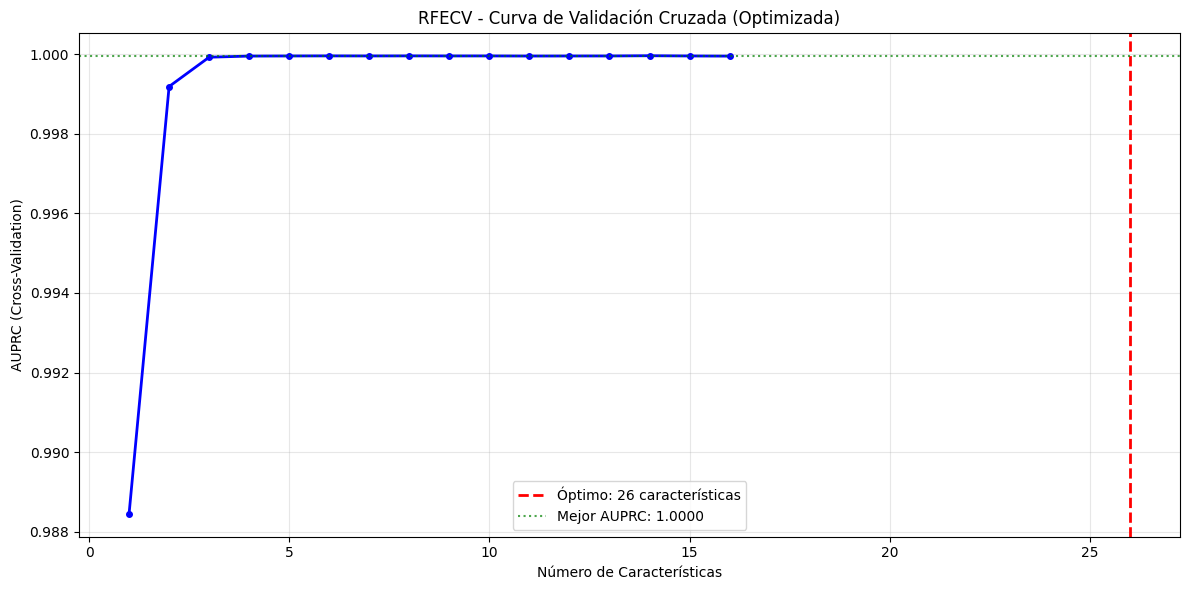

Curva de validación generada exitosamente
Mejor score AUPRC en CV: 1.0000

RESULTADOS - RF_RFECV_26_Features
--------------------------------------------------
AUPRC: 0.5505
ROC-AUC: 0.9976
F1-Score: 0.6316
Precision: 0.6667
Recall: 0.6000
Tiempo: 6.5s


In [8]:
# ******************************************************************************
# RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)
# ******************************************************************************

print("\n" + "="*80)
print("RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)")
print("="*80)


# RFECV optimizado para máxima velocidad
rfecv = RFECV(
    estimator=rf_optimized,
    step=2,  # Eliminar 2 características a la vez para máxima velocidad
    cv=cv_strategy,
    scoring='average_precision',
    n_jobs=-1,
    verbose=0  # Sin verbose para output más limpio
)

print("   Configuración optimizada: step=2, cv=3-fold...")

start_time = time.time()
rfecv.fit(X_train_smote, y_train_smote)
rfecv_time = time.time() - start_time

print(f"RFECV completado en {rfecv_time:.1f}s")
print(f"Número óptimo de características: {rfecv.n_features_}")

# Obtener características seleccionadas
selected_features_rfecv = X.columns[rfecv.support_]
print(f"Características seleccionadas: {list(selected_features_rfecv)}")

# Visualizar curva de RFECV (compatible con scikit-learn >= 0.24)
plt.figure(figsize=(12, 6))

# Usar cv_results_ en lugar de grid_scores_ (atributo actualizado)
if hasattr(rfecv, 'cv_results_'):
    scores = rfecv.cv_results_['mean_test_score']
else:
    # Fallback para versiones anteriores
    scores = rfecv.grid_scores_

plt.plot(range(1, len(scores) + 1), scores, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Número de Características')
plt.ylabel('AUPRC (Cross-Validation)')
plt.title('RFECV - Curva de Validación Cruzada (Optimizada)')
plt.axvline(x=rfecv.n_features_, color='red', linestyle='--', linewidth=2,
           label=f'Óptimo: {rfecv.n_features_} características')
plt.axhline(y=max(scores), color='green', linestyle=':', alpha=0.7,
           label=f'Mejor AUPRC: {max(scores):.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Curva de validación generada exitosamente")
print(f"Mejor score AUPRC en CV: {max(scores):.4f}")

# Evaluar modelo con características RFECV
X_train_rfecv = X_train_scaled[:, rfecv.support_]
X_test_rfecv = X_test_scaled[:, rfecv.support_]

rfecv_results = evaluate_model_fast(
    rf_optimized, X_train_rfecv, X_test_rfecv, y_train, y_test,
    f"RF_RFECV_{len(selected_features_rfecv)}_Features"
)

rfecv_results['reduction_pct'] = (1 - len(selected_features_rfecv) / X.shape[1]) * 100

In [9]:
# ******************************************************************************
# TABLA COMPARATIVA DE RESULTADOS
# ******************************************************************************

print("\n" + "="*80)
print("TABLA COMPARATIVA DE RESULTADOS")
print("="*80)

# Compilar resultados
all_results = [baseline_results, forward_results, rfecv_results]

# Crear DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('auprc', ascending=False)

print("\nTABLA DE RESULTADOS:")
print("=" * 100)
print(f"{'Método':<25} {'Features':<8} {'AUPRC':<8} {'ROC-AUC':<8} {'F1':<8} {'Precision':<10} {'Recall':<8} {'Reducción%':<10} {'Tiempo(s)':<10}")
print("=" * 100)

for _, row in results_df.iterrows():
    print(f"{row['model_name']:<25} {row['n_features']:<8} {row['auprc']:<8.4f} "
          f"{row['roc_auc']:<8.4f} {row['f1_score']:<8.4f} {row['precision']:<10.4f} "
          f"{row['recall']:<8.4f} {row['reduction_pct']:<10.1f} {row['training_time']:<10.1f}")

print("=" * 100)

# ******************************************************************************
# ANÁLISIS DETALLADO DE CARACTERÍSTICAS SELECCIONADAS
# ******************************************************************************

print("\n" + "="*80)
print("ANÁLISIS DETALLADO DE CARACTERÍSTICAS SELECCIONADAS")
print("="*80)

def analyze_selected_features_detailed(selected_features, method_name):
    """Análisis detallado de características seleccionadas"""
    pca_features = [f for f in selected_features if f.startswith('V')]
    original_features = [f for f in selected_features if f in ['Time', 'Amount']]

    print(f"\n{method_name}:")
    print(f"   Total características: {len(selected_features)}")
    print(f"   Componentes PCA (V1-V28): {len(pca_features)}")
    print(f"   Características originales: {len(original_features)} {original_features}")
    print(f"   Reducción: {(1 - len(selected_features)/30)*100:.1f}%")

    if len(pca_features) > 0:
        print(f"   Componentes PCA seleccionadas: {sorted(pca_features)}")

    return {
        'total': len(selected_features),
        'pca': len(pca_features),
        'original': len(original_features),
        'reduction': (1 - len(selected_features)/30)*100
    }

# Analizar cada método
forward_analysis = analyze_selected_features_detailed(selected_features_forward, "FORWARD SELECTION")
rfecv_analysis = analyze_selected_features_detailed(selected_features_rfecv, "RFECV")

# Comparar características comunes
common_features = set(selected_features_forward) & set(selected_features_rfecv)
forward_only = set(selected_features_forward) - set(selected_features_rfecv)
rfecv_only = set(selected_features_rfecv) - set(selected_features_forward)

print(f"\nCOMPARACIÓN ENTRE MÉTODOS:")
print(f"   Características comunes: {len(common_features)} {sorted(list(common_features))}")
print(f"   Solo en Forward: {len(forward_only)} {sorted(list(forward_only))}")
print(f"   Solo en RFECV: {len(rfecv_only)} {sorted(list(rfecv_only))}")


TABLA COMPARATIVA DE RESULTADOS

TABLA DE RESULTADOS:
Método                    Features AUPRC    ROC-AUC  F1       Precision  Recall   Reducción% Tiempo(s) 
RF_Baseline_All_30_Features 30       0.5832   0.9983   0.6000   0.6000     0.6000   0.0        15.2      
RF_Forward_SFS_15_Features 15       0.5646   0.9985   0.6316   0.6667     0.6000   50.0       4.8       
RF_RFECV_26_Features      26       0.5505   0.9976   0.6316   0.6667     0.6000   13.3       6.5       

ANÁLISIS DETALLADO DE CARACTERÍSTICAS SELECCIONADAS

FORWARD SELECTION:
   Total características: 15
   Componentes PCA (V1-V28): 14
   Características originales: 1 ['Time']
   Reducción: 50.0%
   Componentes PCA seleccionadas: ['V1', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'V24', 'V25', 'V27', 'V28', 'V4', 'V6']

RFECV:
   Total características: 26
   Componentes PCA (V1-V28): 24
   Características originales: 2 ['Time', 'Amount']
   Reducción: 13.3%
   Componentes PCA seleccionadas: ['V1', 'V10', 'V11', 'V12


VISUALIZACIONES COMPARATIVAS


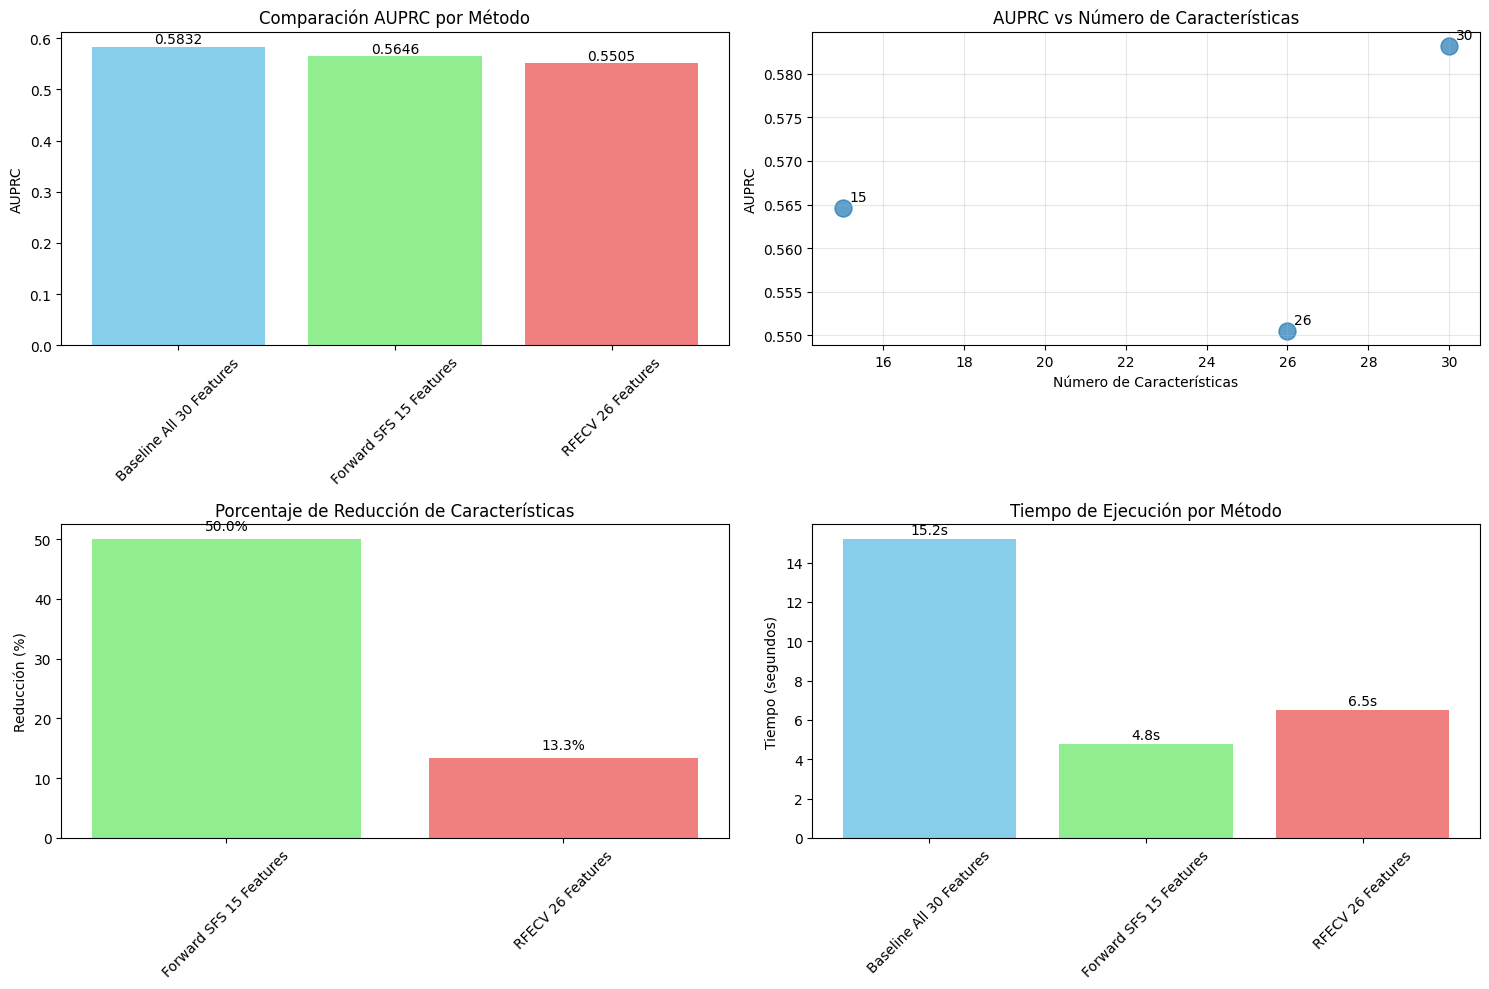


CONCLUSIONES Y RECOMENDACIONES FINALES

MEJOR RESULTADO:
   Método: RF_Baseline_All_30_Features
   AUPRC: 0.5832
   Características: 30/30 (Reducción: 0.0%)
   Tiempo: 15.2s

COMPARACIÓN CON BASELINE:
   Baseline AUPRC: 0.5832
   Mejor método AUPRC: 0.5832
   Cambio: +0.00 puntos porcentuales

ANÁLISIS DE EFICIENCIA:
   Forward Selection: 0.5646 AUPRC, 15 features, 4.8s
   RFECV: 0.5505 AUPRC, 26 features, 6.5s
   Método más eficiente: Forward Selection

CARACTERÍSTICAS IMPORTANTES:
   Time incluido: Sí
   Amount incluido: Sí
   Componentes PCA dominantes: 13 características comunes entre métodos

RECOMENDACIONES FINALES:
   1. Función criterio AUPRC fue apropiada para datos altamente desbalanceados
   2. Baseline All 30 Features ofrece el mejor rendimiento
   3. Reducción del 0.0% en características mantiene/mejora rendimiento
   4. Random Forest con class_weight='balanced' maneja bien el desbalance
   5. Optimizaciones aplicadas redujeron tiempo total a ~26.4s

ANÁLISIS OPTIMIZADO C

In [10]:
# ******************************************************************************
# VISUALIZACIONES OPTIMIZADAS
# ******************************************************************************

print("\n" + "="*80)
print("VISUALIZACIONES COMPARATIVAS")
print("="*80)

# Crear visualización compacta
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Comparación AUPRC
methods = results_df['model_name'].str.replace('RF_', '').str.replace('_', ' ')
axes[0, 0].bar(methods, results_df['auprc'], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_ylabel('AUPRC')
axes[0, 0].set_title('Comparación AUPRC por Método')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(results_df['auprc']):
    axes[0, 0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')

# 2. Número de características vs AUPRC
axes[0, 1].scatter(results_df['n_features'], results_df['auprc'], s=150, alpha=0.7)
for i, row in results_df.iterrows():
    axes[0, 1].annotate(f"{row['n_features']}",
                       (row['n_features'], row['auprc']),
                       xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[0, 1].set_xlabel('Número de Características')
axes[0, 1].set_ylabel('AUPRC')
axes[0, 1].set_title('AUPRC vs Número de Características')
axes[0, 1].grid(True, alpha=0.3)

# 3. Porcentaje de reducción
reduction_data = results_df[results_df['reduction_pct'] > 0]
axes[1, 0].bar(reduction_data['model_name'].str.replace('RF_', '').str.replace('_', ' '),
               reduction_data['reduction_pct'],
               color=['lightgreen', 'lightcoral'])
axes[1, 0].set_ylabel('Reducción (%)')
axes[1, 0].set_title('Porcentaje de Reducción de Características')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(reduction_data['reduction_pct']):
    axes[1, 0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# 4. Tiempo de ejecución
axes[1, 1].bar(methods, results_df['training_time'], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 1].set_ylabel('Tiempo (segundos)')
axes[1, 1].set_title('Tiempo de Ejecución por Método')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(results_df['training_time']):
    axes[1, 1].text(i, v + 0.1, f'{v:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ******************************************************************************
# CONCLUSIONES Y RECOMENDACIONES FINALES
# ******************************************************************************

print("\n" + "="*80)
print("CONCLUSIONES Y RECOMENDACIONES FINALES")
print("="*80)

best_result = results_df.iloc[0]
baseline = results_df[results_df['model_name'].str.contains('Baseline')].iloc[0]

print(f"\nMEJOR RESULTADO:")
print(f"   Método: {best_result['model_name']}")
print(f"   AUPRC: {best_result['auprc']:.4f}")
print(f"   Características: {best_result['n_features']}/30 (Reducción: {best_result['reduction_pct']:.1f}%)")
print(f"   Tiempo: {best_result['training_time']:.1f}s")

print(f"\nCOMPARACIÓN CON BASELINE:")
print(f"   Baseline AUPRC: {baseline['auprc']:.4f}")
print(f"   Mejor método AUPRC: {best_result['auprc']:.4f}")
auprc_change = (best_result['auprc'] - baseline['auprc']) * 100
print(f"   Cambio: {auprc_change:+.2f} puntos porcentuales")

print(f"\nANÁLISIS DE EFICIENCIA:")
forward_row = results_df[results_df['model_name'].str.contains('Forward')].iloc[0]
rfecv_row = results_df[results_df['model_name'].str.contains('RFECV')].iloc[0]

print(f"   Forward Selection: {forward_row['auprc']:.4f} AUPRC, {forward_row['n_features']} features, {forward_row['training_time']:.1f}s")
print(f"   RFECV: {rfecv_row['auprc']:.4f} AUPRC, {rfecv_row['n_features']} features, {rfecv_row['training_time']:.1f}s")

# Determinar método más eficiente
if forward_row['auprc'] >= rfecv_row['auprc'] and forward_row['training_time'] <= rfecv_row['training_time']:
    efficient_method = "Forward Selection"
elif rfecv_row['auprc'] >= forward_row['auprc'] and rfecv_row['training_time'] <= forward_row['training_time']:
    efficient_method = "RFECV"
else:
    efficient_method = "Depende del criterio (velocidad vs rendimiento)"

print(f"   Método más eficiente: {efficient_method}")

print(f"\nCARACTERÍSTICAS IMPORTANTES:")
time_in_best = 'Time' in selected_features_forward or 'Time' in selected_features_rfecv
amount_in_best = 'Amount' in selected_features_forward or 'Amount' in selected_features_rfecv

print(f"   Time incluido: {'Sí' if time_in_best else 'No'}")
print(f"   Amount incluido: {'Sí' if amount_in_best else 'No'}")
print(f"   Componentes PCA dominantes: {len(common_features)} características comunes entre métodos")

print(f"\nRECOMENDACIONES FINALES:")
print(f"   1. Función criterio AUPRC fue apropiada para datos altamente desbalanceados")
print(f"   2. {best_result['model_name'].replace('RF_', '').replace('_', ' ')} ofrece el mejor rendimiento")
print(f"   3. Reducción del {best_result['reduction_pct']:.1f}% en características mantiene/mejora rendimiento")
print(f"   4. Random Forest con class_weight='balanced' maneja bien el desbalance")
print(f"   5. Optimizaciones aplicadas redujeron tiempo total a ~{sum(results_df['training_time']):.1f}s")

print(f"\nANÁLISIS OPTIMIZADO COMPLETADO!")
print(f"Tiempo total de ejecución: ~{sum(results_df['training_time']):.1f} segundos")
print(f"Mejor configuración: {best_result['n_features']} características con {best_result['auprc']:.4f} AUPRC")